In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf

In [42]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_percentage_error,r2_score

In [43]:
!curl -O https://lazyprogrammer.me/course_files/sp500sub.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  0 24.2M    0  134k    0     0  60039      0  0:07:04  0:00:02  0:07:02 60094
  3 24.2M    3  766k    0     0   233k      0  0:01:46  0:00:03  0:01:43  233k
  9 24.2M    9 2382k    0     0   559k      0  0:00:44  0:00:04  0:00:40  560k
 22 24.2M   22 5550k    0     0  1032k      0  0:00:24  0:00:05  0:00:19 1099k
 32 24.2M   32 8062k    0     0  1272k      0  0:00:19  0:00:06  0:00:13 1623k
 42 24.2M   42 10.3M    0     0  1455k      0  0:00:17  0:00:07  0:00:10 2098k
 62 24.2M   62 15.1M    0     0  1862k      0  0:00:13  0:00:08  0:00:05 2922k
 77 24.2M   77 18.9M    0     0  2094k      0  0:00

In [44]:
df0=pd.read_csv('sp500sub.csv',index_col='Date',parse_dates=True)
df0.head()

,Open,High,Low,Close,Adj Close,Volume,Name
Date,,,,,,,
2010-01-04,9.22,9.51,9.17,9.50,9.50,1865400.0,INCY
2010-01-05,9.51,10.29,9.45,10.27,10.27,7608900.0,INCY
2010-01-06,10.38,11.09,10.35,11.00,11.00,8046700.0,INCY
2010-01-07,11.00,11.06,10.62,10.82,10.82,3680300.0,INCY
2010-01-08,10.82,11.00,10.75,10.94,10.94,1529300.0,INCY


In [45]:
df=df0[df0['Name']=='IBM'][['Close']].copy()

In [46]:
df['LogClose']=np.log(df['Close'])

In [47]:
df['DiffLogClose']=df['LogClose'].diff()

In [48]:
Ntest=12
train=df.iloc[:-Ntest]
test=df.iloc[-Ntest:]

In [49]:
# Make supervised dataset
# Let's see if we can use T past values to predict the next value

series=df['DiffLogClose'].to_numpy()[1:] # Numpy array are little easier to index
# It starts from 1 as due to taking the first difference the first value is zero
T=12 # We set the number of lags.
X=[] # We also create empty lists to store inputs and targets
Y=[]

for t in range(len(series)-T):
    x=series[t:t+T] # This is our input which is of the time series of size T
    X.append(x)
    y=series[t+T] # This is to compute the target which is the next value of the time series
    Y.append(y)
    
# We convert both the inputs and targets to the numpy array, which are easy to index    
X=np.array(X).reshape(-1,T)
Y=np.array(Y)
N=len(X)
print('X.shape',X.shape,'Y.shape',Y.shape)

X.shape (2250, 12) Y.shape (2250,)


In [50]:
# To split our input and targets into train and test
Xtrain,Ytrain=X[:-Ntest],Y[:-Ntest]
Xtest,Ytest=X[-Ntest:],Y[-Ntest:]

In [51]:
# To fit a linear regression
lr=LinearRegression()
lr.fit(Xtrain,Ytrain)
lr.score(Xtrain,Ytrain)

0.0055114641154655475

In [52]:
lr.score(Xtest,Ytest)

-0.08823436646150373

In [53]:
# The next step is to create Boolean Index to index both the train and test set
train_idx=df.index<=train.index[-1]
test_idx=~train_idx
train_idx[:T+1]=False # first T+1 values are not predictable

In [54]:
# Needed to compute un-differenced predictions
df['ShiftLogClose']=df['LogClose'].shift(1)
prev=df['ShiftLogClose']

In [55]:
# Last-known train value
last_train=train.iloc[-1]['LogClose']

In [56]:
# To assign the 1 step forecast to the dataframe
df.loc[train_idx,'LR_1step_train']=prev[train_idx]+lr.predict(Xtrain)
df.loc[test_idx,'LR_1step_test']=prev[test_idx]+lr.predict(Xtest)

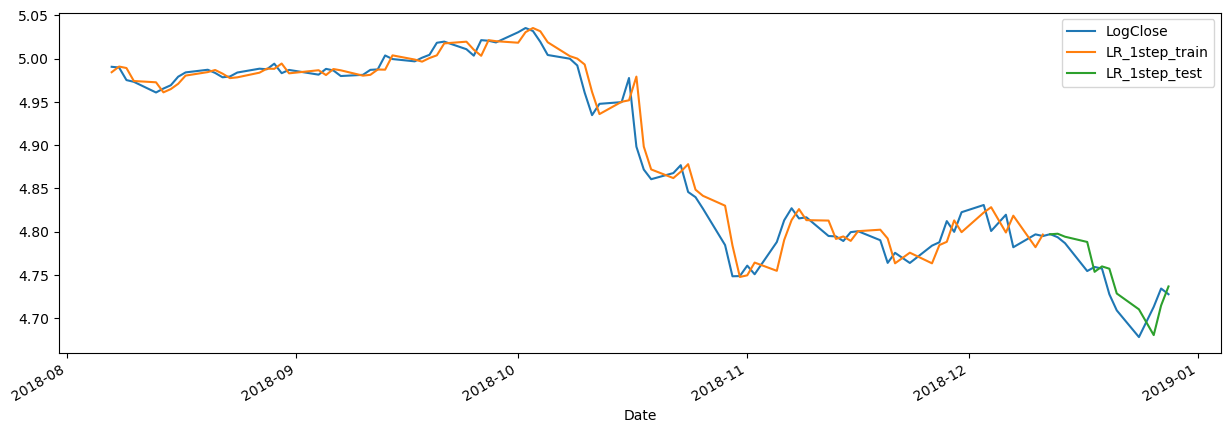

In [57]:
# to plot our 1 step forecast
cols=['LogClose','LR_1step_train','LR_1step_test']
df.iloc[-100:][cols].plot(figsize=(15,5));

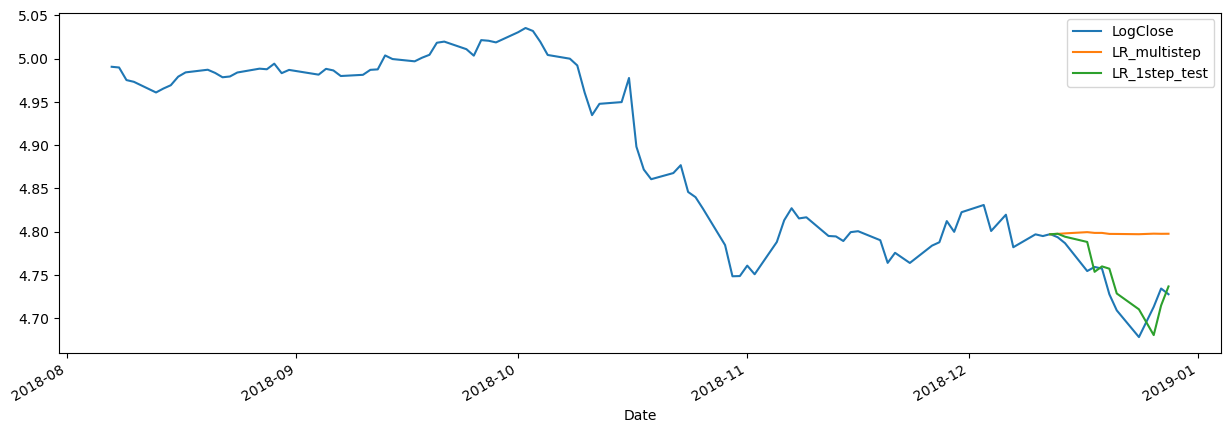

In [58]:
# results look pretty good
multistep_predictions=[] # empty list to store our predictions

#to obtain the first test input
last_x=Xtest[0]  # This variable will be updated as we go through the loop

while len(multistep_predictions)< Ntest:
    p=lr.predict(last_x.reshape(1,-1))[0] # we have to reshape as scikit learn only accepts 2 d array as input
    # ...continued. Data has to be in the form of a table with samples along the rows and features along the columns.
    # we index the prediction to 0, [0] since there is only one prediction
    
    # update the predictions list
    multistep_predictions.append(p) # to append our prediction to a list of predictions
    
    # make the new input
    last_x=np.roll(last_x,-1) # update last x, basically throw out the oldest value and append the newest value
    last_x[-1]=p
    # First we rotate the values by one step: roll[1,2,3,4,5] -> [2,3,4,5,1] then we assign at -1 
    #...for example we want to assign 6 then the list will become [2,3,4,5,6]
    
    
# save multi-step forecast to dataframe
df.loc[test_idx,'LR_multistep']=last_train+np.cumsum(multistep_predictions)

# plot 1-step and multi-step forecast
cols=['LogClose','LR_multistep','LR_1step_test']
df.iloc[-100:][cols].plot(figsize=(15,5));

In [59]:
# Lets create a multi output model
# make multi-output supervised dataset
Tx=T # Number of timesteps in the input
Ty=Ntest # Number of steps in the output
X=[]
Y=[]
for t in range(len(series)-Tx-Ty+1):
    x=series[t:t+Tx]
    X.append(x)
    y=series[t+Tx:t+Tx+Ty] # the loop has a length of Ty
    Y.append(y)
    
X=np.array(X).reshape(-1,Tx)
Y=np.array(Y).reshape(-1,Ty)
N=len(X)
print('X.shape',X.shape,'Y.shape',Y.shape)

X.shape (2239, 12) Y.shape (2239, 12)


In [60]:
Xtrain_m,Ytrain_m=X[:-1],Y[:-1]
Xtest_m,Ytest_m=X[-1:],Y[-1:]

In [61]:
lr=LinearRegression()
lr.fit(Xtrain_m,Ytrain_m)
lr.score(Xtrain_m,Ytrain_m)

0.005128313388965615

In [62]:
r2_score(lr.predict(Xtest_m).flatten(),Ytest_m.flatten())

-473.0963674858702

In [63]:
# Save multi-output forecast to dataframe
df.loc[test_idx,'LR_multioutput']= last_train+\
np.cumsum(lr.predict(Xtest_m).flatten())

<Axes: xlabel='Date'>

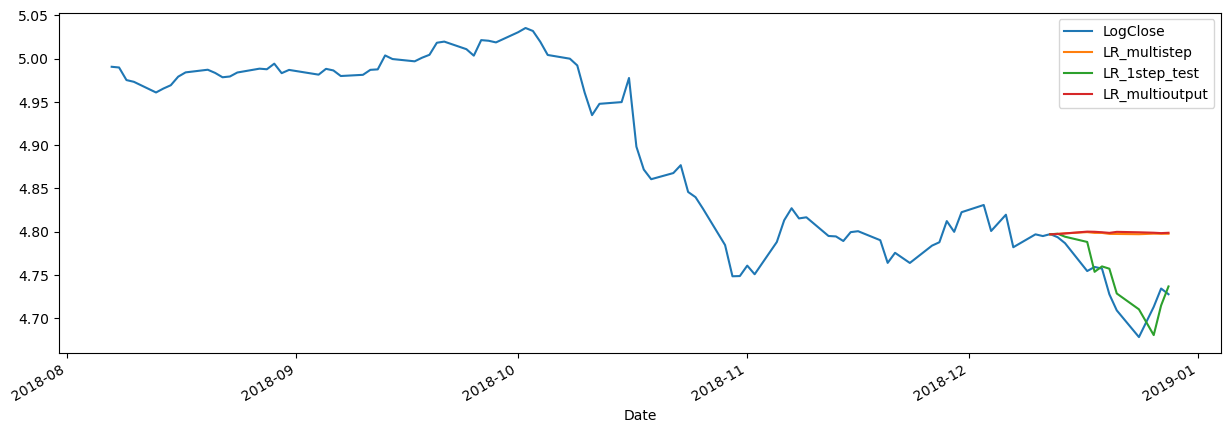

In [65]:
# plot all forecast
cols=['LogClose','LR_multistep','LR_1step_test','LR_multioutput']
df.iloc[-100:][cols].plot(figsize=(15,5))

In [67]:
# MAPE
test_log_pass=df.iloc[-Ntest:]['LogClose']
mape1=mean_absolute_percentage_error(test_log_pass,df.loc[test_idx,'LR_multistep'])
print('multi-step MAPE:',mape1)
mape2=mean_absolute_percentage_error(
test_log_pass,df.loc[test_idx,'LR_multioutput'])
print('multi-output MAPE',mape2)

multi-step MAPE: 0.01121888378069776
multi-output MAPE 0.011418709227427326


# Test Other Models

In [70]:
def one_step_and_multistep_forecast(model,name):
    model.fit(Xtrain,Ytrain)
    print('One-step forecast:',name)
    # print('Train R^2:',model.score(Xtrain,Ytrain))
    # print('Test R^2(1-step):',model.score(Xtest,Ytest))
    
    # store 1-step forecast
    df.loc[train_idx,f'{name}_1step_train']=prev[train_idx]+model.predict(Xtrain)
    df.loc[test_idx,f'{name}_1step_test']=prev[test_idx]+model.predict(Xtest)
    
    # generate multi-step forecast
    multistep_predictions=[]
    
    # first test input
    last_x=Xtest[0]
    
    while len(multistep_predictions)<Ntest:
        p=model.predict(last_x.reshape(1,-1))[0]
        
        #update the prediction list
        multistep_predictions.append(p)
        
        # make the new input
        last_x=np.roll(last_x,-1)
        last_x[-1]=p
        
    # store multi-step forecast
    df.loc[test_idx,f'{name}_multistep_test']=last_train+np.cumsum(multistep_predictions)
    
    #MAPE of multi-step forecast
    test_log_pass=df.iloc[-Ntest:]["LogClose"]
    mape= mean_absolute_percentage_error(test_log_pass,df.loc[test_idx,f'{name}_multistep_test'])
    print('Test MAPE (multistep):',mape)
    
    #plot 1-step and multistep forecast
    cols=[
        'LogClose',
        f'{name}_1step_train',
        f'{name}_1step_test',
        f'{name}_multistep_test'
    ]
    df.iloc[-100:][cols].plot(figsize=(15,5));
        

One-step forecast: SVR
Test MAPE (multistep): 0.009692971150318395


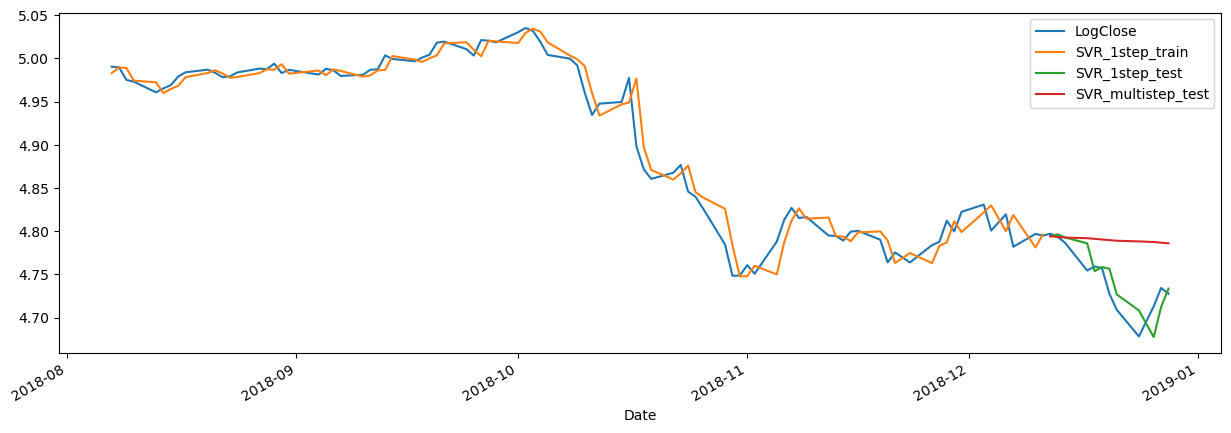

In [71]:
one_step_and_multistep_forecast(SVR(),'SVR')

One-step forecast: RF
Test MAPE (multistep): 0.014131479728265261


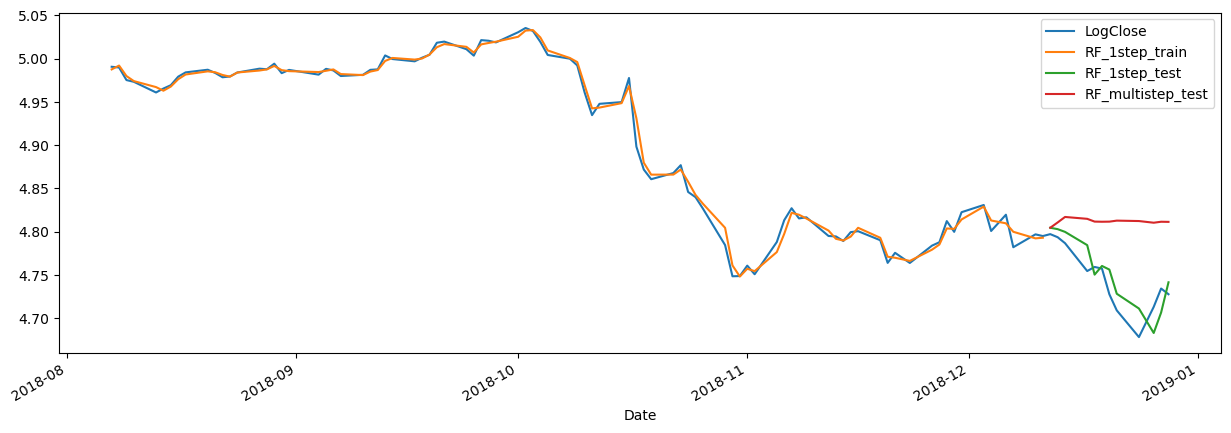

In [72]:
## SVM doesn't peform that well, but this is without differencing
one_step_and_multistep_forecast(RandomForestRegressor(),'RF')

In [75]:
def multi_output_forecast(model,name):
    model.fit(Xtrain_m,Ytrain_m)
    
    # save multioutput forecast to dataframe
    df.loc[test_idx,f'{name}_multioutput']=last_train+np.cumsum(model.predict(Xtest_m).flatten())
    test_log_pass=df.iloc[-Ntest:]["LogClose"]
    mape=mean_absolute_percentage_error(
    test_log_pass,df.loc[test_idx,f'{name}_multioutput'])
    print('Test MAPE (multi-output):',mape)
    
    #plot all forecasts
    #assume that previous functions have been run
    cols=[
        'LogClose',
        f'{name}_1step_train',
        f'{name}_1step_test',
        f'{name}_multistep_test',
        f'{name}_multioutput',
    ]
    df.iloc[-100:][cols].plot(figsize=(15,5));

Test MAPE (multi-output): 0.012456600998922552


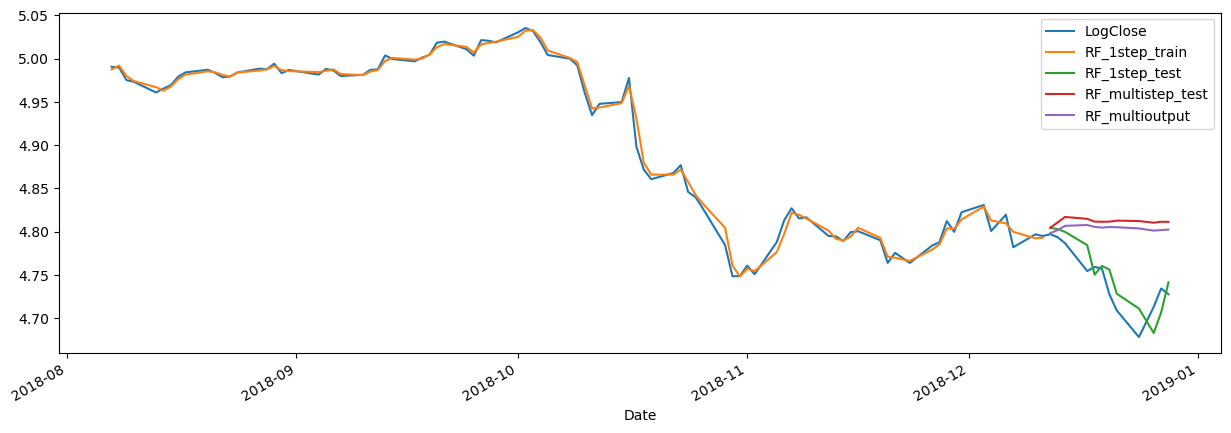

In [76]:
# doesn't perform too well
multi_output_forecast(RandomForestRegressor(),'RF')

In [77]:
# the lesson is that both linear and non linear models fail to predict stocks